In [1]:
# BMI 데이터를 학습을 통해 예측하는 머신
import pandas as pd
import numpy as np

In [2]:
# 데이터 확인 
csv = pd.read_csv("data/bmi.csv")
print("shape of csv:", csv.shape)
csv.head()

shape of csv: (20000, 3)


,label,height,weight
0,normal,188,71
1,fat,161,68
2,thin,178,52
3,fat,136,63
4,normal,145,52


In [3]:
# weight, height의 통계량 확인
csv.describe()

,height,weight
count,20000.000000,20000.000000
mean,160.092050,57.377650
std,23.385464,13.260121
min,120.000000,35.000000
25%,140.000000,46.000000
50%,160.000000,57.000000
75%,180.000000,69.000000
max,200.000000,80.000000


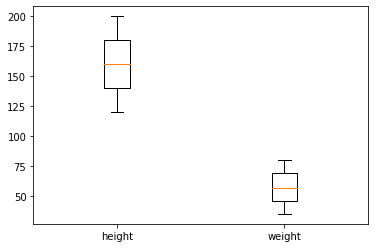

In [4]:
%matplotlib inline
# maplotlib로 weight와 height의 분포확인 (Boxplot)
import matplotlib.pyplot as plt
plt.boxplot([csv['height'], csv['weight']], labels=['height', 'weight'])
plt.show()
# 입력 데이터가 크면 포화상태가 발생하여 식별력을 잃는다.
# 실제 입력 데이터는 0.0~1.0 사이의 범위로 정규화가 필요

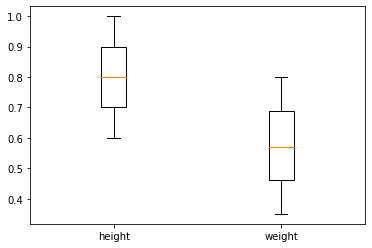

In [5]:
# 원본 보존
scsv = csv.copy()
# 정규화 수행
scsv['height'] = scsv['height']/200
scsv['weight'] = scsv['weight']/100
# 분포 재확인
plt.boxplot([scsv['height'], scsv['weight']], labels=['height', 'weight'])
plt.show()

In [6]:
# Label 데이터 마련, str -> One Hot Encoding 방식으로 컨버팅 
# thin = (1, 0, 0), normal = (0, 1, 0), fat = (0, 0, 1)
bclass = {"thin": (1, 0, 0),
         "normal": (0, 1, 0),
         "fat": (0, 0, 1)}
# 파생 변수로 One Hot Encoding Label 컬럼 생성
scsv['label_pat'] = scsv['label'].apply(lambda x: np.array(bclass[x]))
# .apply : 판다스(넘파이)의 기존 함수 이외의 사용자 정의 함수를 Braodcasting 하는 메서드 
# 데이터 확인 : One Hot Encoding 이 잘 적용되었는가? 
scsv.head()

,label,height,weight,label_pat
0,normal,0.940,0.71,"[0, 1, 0]"
1,fat,0.805,0.68,"[0, 0, 1]"
2,thin,0.890,0.52,"[1, 0, 0]"
3,fat,0.680,0.63,"[0, 0, 1]"
4,normal,0.725,0.52,"[0, 1, 0]"


In [7]:
# 테스트 데이터 분리 
test_csv = scsv[15000:] # 5000개의 테스트 데이터 분리
test_pat = test_csv[['weight', 'height']]
test_ans = list(test_csv['label_pat'])
print(test_pat.head())
print(test_ans[:5])

       weight  height
15000    0.47   0.670
15001    0.42   0.830
15002    0.67   0.775
15003    0.68   0.800
15004    0.77   0.940
[array([0, 0, 1]), array([1, 0, 0]), array([0, 0, 1]), array([0, 0, 1]), array([0, 1, 0])]


In [8]:
# Tensorflow로 힉습 모델 구성
import tensorflow as tf
tf.reset_default_graph()

# 신경망의 구성
# 재현성 확보를 위한 난수 seed의 정의 
#np.random.seed(seed=42)
tf.set_random_seed(seed=42)
x = tf.placeholder(tf.float32, [None, 2], name="x") # ?행 2열 데이터, ['height', 'weight'] -> 2개의 feature
y_ = tf.placeholder(tf.float32, [None, 3], name="y_") # BMI 라벨의 개수(총 3개)
# 변수 선언 
W = tf.Variable(tf.random_normal([2, 3]), name="W") # 가중치
b = tf.Variable(tf.random_normal([3], name="b")) # 절편

# 출력의 Softmax 회귀
y = tf.nn.softmax(tf.matmul(x, W)+b) # fn(x) = Wx + b -> Softmax 활성화 함수 

In [9]:
# 모델 훈련
# 오차 함수(Cross Entropy 함수)
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))

# 최적화 : 경사하강법
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer.minimize(cross_entropy) # 오차 함수를 활용한 가중치와 편차의 보정

# 정답률 구하기
predict = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(predict, tf.float32))

In [10]:
# 실제 실행은 Session에서 실행
with tf.Session() as sess:
    tf.summary.FileWriter("d:/log_dir/bmi", graph=sess.graph)
    # 변수의 초기화
    sess.run(tf.global_variables_initializer())
    print("초기 가중치:", sess.run(W))
    print("초기 절편:", sess.run(b))
    
    # 학습 수행
    for step in range(3500): # 3500번 학습
        # 학습 데이터 0~14999까지
        i = (step*100)%14000 # 100개씩 학습
        # 학습대상이 되는 row 추출
        rows = scsv[i+1 : i+1+100]
        
        # 학습 데이터와 학습라벨 분리
        x_pat = rows[['weight', 'height']]
        y_ans = list(rows['label_pat'])
        # 텐서플로 placeholder에 넘겨줄 테이더를 사전으로 마련 
        fd = {x:x_pat, y_:y_ans}
        sess.run(train, feed_dict=fd)
        if step%500==0: # 중간 결과 확인
            # 학습도니 모델로 test데이터를 평가
            cre = sess.run(cross_entropy, feed_dict={x:test_pat, y_:test_ans})
            acc = sess.run(accuracy, feed_dict={x:test_pat, y_:test_ans})
            print("Step:{}, CrossEntropy:{}, 정확도:{}".format(step, cre, acc))
        # 최종 정답률 구하기
        acc = sess.run(accuracy, feed_dict={x:test_pat, y_:test_ans})
        print("최종 정답률:", acc)
        
        # 최종 학습도니 가중치와 절편
        print("최종 가중치:\n", sess.run(W))
        print("최종 절편:\n", sess.run(b))

초기 가중치: [[ 1.080044   -2.473193   -1.5754302 ]
 [-0.40005195  0.4460453   0.21750373]]
초기 절편: [ 0.07774825 -1.004884   -0.12903629]
Step:0, CrossEntropy:6707.3525390625, 정확도:0.061000000685453415
최종 정답률: 0.061
최종 가중치:
 [[ 0.8024221  -2.3693643  -1.4016368 ]
 [-0.68517554  0.58240324  0.3662694 ]]
최종 절편:
 [-0.31073138 -0.8484571   0.1030163 ]
최종 정답률: 0.0744
최종 가중치:
 [[ 0.70072097 -2.2620173  -1.4072827 ]
 [-0.73834485  0.73020124  0.2716407 ]]
최종 절편:
 [-0.42221507 -0.66753894  0.03358179]
최종 정답률: 0.2316
최종 가중치:
 [[ 0.5656452  -2.144066   -1.390158  ]
 [-0.84330285  0.8924569   0.2143431 ]]
최종 절편:
 [-0.5946124  -0.47155237  0.00999255]
최종 정답률: 0.178
최종 가중치:
 [[ 0.5345102  -2.133522   -1.3695672 ]
 [-0.79378843  0.89406645  0.1632191 ]]
최종 절편:
 [-0.5742892  -0.48413622  0.00225318]
최종 정답률: 0.1658
최종 가중치:
 [[ 0.4899373  -2.1224     -1.3361162 ]
 [-0.7545      0.8975244   0.12047268]]
최종 절편:
 [-0.56542206 -0.48808962 -0.00266056]
최종 정답률: 0.1866
최종 가중치:
 [[ 0.47002152 -2.0522127  -1.3863877 ]

최종 가중치:
 [[-2.0440948  -1.6275283   0.70304465]
 [ 1.3283015   0.89170235 -1.9565063 ]]
최종 절편:
 [-0.75154966 -0.7340387   0.42941567]
최종 정답률: 0.5712
최종 가중치:
 [[-2.096044   -1.6023177   0.72978336]
 [ 1.3099518   0.92931086 -1.9757649 ]]
최종 절편:
 [-0.80646664 -0.69081926  0.44111323]
최종 정답률: 0.5084
최종 가중치:
 [[-2.1251006  -1.6027237   0.7592459 ]
 [ 1.3231182   0.93104154 -1.9906621 ]]
최종 절편:
 [-0.82422537 -0.69563466  0.4636874 ]
최종 정답률: 0.6996
최종 가중치:
 [[-2.1069314 -1.5987797  0.7371328]
 [ 1.4204168  0.9123269 -2.069246 ]]
최종 절편:
 [-0.74107677 -0.72087264  0.40577674]
최종 정답률: 0.7008
최종 가중치:
 [[-2.141934  -1.5918953  0.765251 ]
 [ 1.4264418  0.9238551 -2.0867991]]
최종 절편:
 [-0.76968527 -0.7012718   0.41478434]
최종 정답률: 0.6996
최종 가중치:
 [[-2.1491125 -1.6121979  0.7927322]
 [ 1.4781809  0.8867021 -2.1013854]]
최종 절편:
 [-0.7410515 -0.7503447  0.4352235]
최종 정답률: 0.6898
최종 가중치:
 [[-2.2074738 -1.6332268  0.8721224]
 [ 1.4595274  0.8586858 -2.0547156]]
최종 절편:
 [-0.79668206 -0.7924237   0.53293306]

최종 절편:
 [-0.9045075  -0.91928506  0.7676207 ]
최종 정답률: 0.765
최종 가중치:
 [[-3.4219978 -1.2716006  1.7250208]
 [ 2.5986605  0.9506626 -3.2858248]]
최종 절편:
 [-0.9262346  -0.8748276   0.74489033]
최종 정답률: 0.6996
최종 가중치:
 [[-3.4552624 -1.3132255  1.7999103]
 [ 2.60239    0.8891104 -3.228002 ]]
최종 절편:
 [-0.9543665  -0.9546994   0.85289407]
최종 정답률: 0.7758
최종 가중치:
 [[-3.487725   -1.2616341   1.7807815 ]
 [ 2.5970743   0.95826507 -3.291841  ]]
최종 절편:
 [-0.9818207  -0.8769945   0.80264336]
최종 정답률: 0.6996
최종 가중치:
 [[-3.4886544  -1.2905136   1.8105905 ]
 [ 2.6480021   0.90923387 -3.2937376 ]]
최종 절편:
 [-0.94975966 -0.9389857   0.83257353]
최종 정답률: 0.708
최종 가중치:
 [[-3.5351737 -1.2862403  1.8528365]
 [ 2.6241255  0.9231817 -3.283809 ]]
최종 절편:
 [-1.0066339  -0.92022014  0.8706821 ]
최종 정답률: 0.6996
최종 가중치:
 [[-3.5388248  -1.3172494   1.8874968 ]
 [ 2.6711495   0.87344587 -3.2810972 ]]
최종 절편:
 [-0.9711601 -0.9896759  0.9046641]
최종 정답률: 0.6996
최종 가중치:
 [[-3.5591369  -1.2863723   1.8769318 ]
 [ 2.6866999   0.912

최종 정답률: 0.7346
최종 가중치:
 [[-4.5506377  -1.0467681   2.6288292 ]
 [ 3.5642447   0.94794285 -4.248689  ]]
최종 절편:
 [-1.1876792 -1.043666   1.1751739]
최종 정답률: 0.7866
최종 가중치:
 [[-4.5623555  -1.0216469   2.615426  ]
 [ 3.5851338   0.97939444 -4.3010297 ]]
최종 절편:
 [-1.1834834 -1.0089139  1.136226 ]
최종 정답률: 0.863
최종 가중치:
 [[-4.6001577 -0.959298   2.5908797]
 [ 3.562834   1.0698887 -4.369224 ]]
최종 절편:
 [-1.2302368  -0.89562136  1.069687  ]
최종 정답률: 0.863
최종 가중치:
 [[-4.6362934 -0.9735967  2.641314 ]
 [ 3.5439796  1.0585651 -4.339046 ]]
최종 절편:
 [-1.2767396 -0.914904   1.1354725]
최종 정답률: 0.7346
최종 가중치:
 [[-4.624615  -1.0394428  2.695482 ]
 [ 3.6067975  0.9610636 -4.3043623]]
최종 절편:
 [-1.2244959 -1.0399222  1.2082471]
최종 정답률: 0.7978
최종 가중치:
 [[-4.6493793 -0.9983438  2.6791472]
 [ 3.6097875  1.0089191 -4.355208 ]]
최종 절편:
 [-1.2357689  -0.99863553  1.1782334 ]
최종 정답률: 0.772
최종 가중치:
 [[-4.6809196 -0.9960388  2.7083826]
 [ 3.6009562  1.0121844 -4.349642 ]]
최종 절편:
 [-1.2663378 -1.0028758  1.2130425]
최종 정답

최종 정답률: 0.778
최종 가중치:
 [[-5.7707815 -0.7859754  3.5881798]
 [ 4.8157663  1.0225422 -5.5748096]]
최종 절편:
 [-1.4672979 -1.1972413  1.6083694]
최종 정답률: 0.7836
최종 가중치:
 [[-5.8029647  -0.78179127  3.616179  ]
 [ 4.7953787   1.0375055  -5.569385  ]]
최종 절편:
 [-1.5125386 -1.1764052  1.632774 ]
최종 정답률: 0.723
최종 가중치:
 [[-5.7972474  -0.82060695  3.6492777 ]
 [ 4.839376    0.9800107  -5.5558877 ]]
최종 절편:
 [-1.4751853 -1.2536836  1.6726991]
최종 정답률: 0.7676
최종 가중치:
 [[-5.8147955  -0.79065067  3.6368694 ]
 [ 4.842859    1.020177   -5.5995364 ]]
최종 절편:
 [-1.4898987 -1.2044574  1.6381863]
최종 정답률: 0.8596
최종 가중치:
 [[-5.8674726  -0.73051375  3.6294098 ]
 [ 4.788731    1.1083317  -5.6335635 ]]
최종 절편:
 [-1.5740669 -1.099963   1.61786  ]
최종 정답률: 0.7984
최종 가중치:
 [[-5.8529043  -0.76362497  3.6479526 ]
 [ 4.846972    1.0530665  -5.636539  ]]
최종 절편:
 [-1.519652  -1.1778398  1.6413219]
최종 정답률: 0.7954
최종 가중치:
 [[-5.8568125 -0.7650786  3.6533146]
 [ 4.873906   1.0471838 -5.6575904]]
최종 절편:
 [-1.5023209 -1.1903211  1.6

최종 정답률: 0.8236
최종 가중치:
 [[-6.5521913 -0.6069973  4.1906133]
 [ 5.4999533  1.1155483 -6.352002 ]]
최종 절편:
 [-1.7737089 -1.2153946  1.9329343]
최종 정답률: 0.8406
최종 가중치:
 [[-6.5530477 -0.6080979  4.1925707]
 [ 5.5247827  1.1191334 -6.380417 ]]
최종 절편:
 [-1.7595497 -1.2077434  1.9111239]
최종 정답률: 0.7714
최종 가중치:
 [[-6.558234   -0.64351475  4.233174  ]
 [ 5.549759    1.0652217  -6.3514814 ]]
최종 절편:
 [-1.7477806 -1.2779174  1.9695287]
최종 정답률: 0.7682
최종 가중치:
 [[-6.5822773  -0.64104366  4.254746  ]
 [ 5.5395646   1.0733508  -6.3494163 ]]
최종 절편:
 [-1.775998  -1.2738644  1.9936931]
최종 정답률: 0.8622
최종 가중치:
 [[-6.607445  -0.5849418  4.223811 ]
 [ 5.523753   1.1558076 -6.4160614]]
최종 절편:
 [-1.812921  -1.1716213  1.9283731]
최종 정답률: 0.8424
최종 가중치:
 [[-6.6211     -0.59774256  4.250267  ]
 [ 5.5307803   1.1467965  -6.4140773 ]]
최종 절편:
 [-1.8193576 -1.1819655  1.9451538]
최종 정답률: 0.8018
최종 가중치:
 [[-6.5956883 -0.6289508  4.256064 ]
 [ 5.6027327  1.0879421 -6.427175 ]]
최종 절편:
 [-1.7489994 -1.260921   1.953751 ]
최종

 [-1.9389375 -1.2950668  2.1778352]
최종 정답률: 0.794
최종 가중치:
 [[-7.133764   -0.52971476  4.694902  ]
 [ 6.2345676   1.096495   -7.067564  ]]
최종 절편:
 [-1.9268973 -1.349133   2.2198613]
최종 정답률: 0.7974
최종 가중치:
 [[-7.151933  -0.5256996  4.709056 ]
 [ 6.228216   1.1084143 -7.0731316]]
최종 절편:
 [-1.9514506 -1.3368666  2.2321482]
최종 정답률: 0.8602
최종 가중치:
 [[-7.1747146  -0.48922044  4.6953583 ]
 [ 6.2168283   1.1644831  -7.117812  ]]
최종 절편:
 [-1.9792197 -1.2648747  2.1879253]
최종 정답률: 0.799
최종 가중치:
 [[-7.142791   -0.53995305  4.714167  ]
 [ 6.290965    1.0936594  -7.121125  ]]
최종 절편:
 [-1.9097308 -1.3477621  2.201324 ]
최종 정답률: 0.8228
최종 가중치:
 [[-7.187568  -0.5145898  4.7335815]
 [ 6.2459645  1.1347835 -7.1172485]]
최종 절편:
 [-1.9773462 -1.3049905  2.2261677]
최종 정답률: 0.8098
최종 가중치:
 [[-7.1637187 -0.5307352  4.7258773]
 [ 6.3102636  1.1042209 -7.1509852]]
최종 절편:
 [-1.9177063 -1.3374894  2.1990266]
최종 정답률: 0.8952
최종 가중치:
 [[-7.2081823  -0.45497912  4.694585  ]
 [ 6.264074    1.212102   -7.2126765 ]]
최종 절편

최종 절편:
 [-2.3109307 -1.2885821  2.5433452]
최종 정답률: 0.871
최종 가중치:
 [[-7.9478745  -0.37317538  5.3524747 ]
 [ 7.0235386   1.2323691  -7.992406  ]]
최종 절편:
 [-2.3162696 -1.2953693  2.5554714]
최종 정답률: 0.8282
최종 가중치:
 [[-7.9219437 -0.4052986  5.358667 ]
 [ 7.0902414  1.17378   -8.00052  ]]
최종 절편:
 [-2.2499003 -1.3733056  2.5670383]
최종 정답률: 0.8216
최종 가중치:
 [[-7.928643   -0.41255292  5.3726206 ]
 [ 7.1015472   1.1666601  -8.004705  ]]
최종 절편:
 [-2.2493885 -1.3839434  2.5771642]
최종 정답률: 0.815
최종 가중치:
 [[-7.935601  -0.413044   5.3800697]
 [ 7.117133   1.1604681 -8.014099 ]]
최종 절편:
 [-2.2398863 -1.3982626  2.5819814]
최종 정답률: 0.7906
최종 가중치:
 [[-7.912483   -0.43666458  5.3805723 ]
 [ 7.174655    1.1229441  -8.034097  ]]
최종 절편:
 [-2.1880333 -1.4416696  2.5735354]
최종 정답률: 0.793
최종 가중치:
 [[-7.902603   -0.43130413  5.365332  ]
 [ 7.214404    1.1203567  -8.071259  ]]
최종 절편:
 [-2.1545835 -1.4456885  2.5441046]
최종 정답률: 0.8184
최종 가중치:
 [[-7.924314   -0.40887532  5.364614  ]
 [ 7.206455    1.1468834  -8.0898

최종 절편:
 [-2.440018 -1.409113  2.792964]
최종 정답률: 0.8952
최종 가중치:
 [[-8.508967   -0.30045488  5.8408484 ]
 [ 7.9185066   1.2297727  -8.884777  ]]
최종 절편:
 [-2.465384  -1.3720877  2.7813046]
최종 정답률: 0.844
최종 가중치:
 [[-8.503617   -0.33080518  5.8658485 ]
 [ 7.9493146   1.183037   -8.86885   ]]
최종 절편:
 [-2.4424527 -1.4330487  2.8193343]
최종 정답률: 0.9014
최종 가중치:
 [[-8.539544   -0.29135573  5.862326  ]
 [ 7.9109254   1.2416109  -8.889034  ]]
최종 절편:
 [-2.507685  -1.3589659  2.8104837]
최종 정답률: 0.8868
최종 가중치:
 [[-8.543676   -0.29844725  5.8735504 ]
 [ 7.928321    1.2290056  -8.893825  ]]
최종 절편:
 [-2.496565  -1.3785869  2.8189847]
최종 정답률: 0.8498
최종 가중치:
 [[-8.544546   -0.32018685  5.89616   ]
 [ 7.9496393   1.1950333  -8.881171  ]]
최종 절편:
 [-2.4837158 -1.4235228  2.8510714]
최종 정답률: 0.8972
최종 가중치:
 [[-8.574223   -0.28580242  5.8914523 ]
 [ 7.9224863   1.24551    -8.904495  ]]
최종 절편:
 [-2.5325909 -1.3585719  2.8349955]
최종 정답률: 0.886
최종 가중치:
 [[-8.578939  -0.295572   5.9059386]
 [ 7.9362955  1.2322441 -8

최종 정답률: 0.908
최종 가중치:
 [[-9.115824   -0.23815279  6.385402  ]
 [ 8.5746975   1.2777911  -9.588984  ]]
최종 절편:
 [-2.7815626 -1.3688704  3.0942657]
최종 정답률: 0.9086
최종 가중치:
 [[-9.107736  -0.234565   6.3737264]
 [ 8.608039   1.2720549 -9.616589 ]]
최종 절편:
 [-2.753791  -1.378606   3.0762298]
최종 정답률: 0.9064
최종 가중치:
 [[-9.130298   -0.20636225  6.368086  ]
 [ 8.594249    1.3051418  -9.635885  ]]
최종 절편:
 [-2.7793882 -1.3459768  3.0691977]
최종 정답률: 0.9136
최종 가중치:
 [[-9.137423   -0.21456373  6.3834124 ]
 [ 8.604221    1.2925899  -9.6333065 ]]
최종 절편:
 [-2.7786262 -1.3659583  3.088417 ]
최종 정답률: 0.882
최종 가중치:
 [[-9.144157  -0.2418585  6.417442 ]
 [ 8.6115465  1.2589496 -9.606991 ]]
최종 절편:
 [-2.7835786 -1.4105667  3.1379778]
최종 정답률: 0.8244
최종 가중치:
 [[-9.127616   -0.28008574  6.439128  ]
 [ 8.653771    1.2005692  -9.590836  ]]
최종 절편:
 [-2.7511258 -1.4854574  3.1804159]
최종 정답률: 0.9028
최종 가중치:
 [[-9.14829    -0.22356412  6.4032807 ]
 [ 8.639173    1.275491   -9.651159  ]]
최종 절편:
 [-2.7789378 -1.3963213  3.1

최종 정답률: 0.8792
최종 가중치:
 [[ -9.430146    -0.22196831   6.683545  ]
 [  9.0996065    1.2520708  -10.088175  ]]
최종 절편:
 [-2.8988588 -1.440636   3.2833278]
최종 정답률: 0.907
최종 가중치:
 [[ -9.445265   -0.2036454   6.6803412]
 [  9.093039    1.2779182 -10.107454 ]]
최종 절편:
 [-2.9219325 -1.403866   3.2696314]
최종 정답률: 0.8618
최종 가중치:
 [[ -9.438035    -0.23340207   6.7028685 ]
 [  9.123627     1.2324084  -10.092533  ]]
최종 절편:
 [-2.897719  -1.4627396  3.3042912]
최종 정답률: 0.9108
최종 가중치:
 [[ -9.470616    -0.19573894   6.697787  ]
 [  9.087829     1.2886167  -10.112943  ]]
최종 절편:
 [-2.9581006 -1.3911892  3.2931223]
최종 정답률: 0.9024
최종 가중치:
 [[ -9.47387     -0.20249781   6.7078    ]
 [  9.10372      1.276791   -10.117008  ]]
최종 절편:
 [-2.9474761 -1.4094446  3.300753 ]
최종 정답률: 0.8646
최종 가중치:
 [[ -9.472582    -0.22471529   6.7287292 ]
 [  9.12545      1.2424318  -10.104379  ]]
최종 절편:
 [-2.9328752 -1.4542478  3.3309555]
최종 정답률: 0.9106
최종 가중치:
 [[ -9.500318    -0.19120087   6.7229505 ]
 [  9.098644     1.2920166  -

최종 가중치:
 [[ -9.867253    -0.15952067   7.058204  ]
 [  9.417336     1.3360147  -10.48985   ]]
최종 절편:
 [-3.2292118 -1.3678007  3.540846 ]
최종 정답률: 0.8696
최종 가중치:
 [[ -9.841188    -0.19255082   7.06517   ]
 [  9.477872     1.2778254  -10.492196  ]]
최종 절편:
 [-3.167507  -1.4444151  3.5557556]
최종 정답률: 0.862
최종 가중치:
 [[ -9.845737   -0.19964     7.0768085]
 [  9.487228    1.2703227 -10.49405  ]]
최종 절편:
 [-3.1665907 -1.4539871  3.5644114]
최종 정답률: 0.8586
최종 가중치:
 [[ -9.8491125   -0.20023206   7.0807757 ]
 [  9.501823     1.2647632  -10.503086  ]]
최종 절편:
 [-3.1556664 -1.466675   3.566175 ]
최종 정답률: 0.8284
최종 가중치:
 [[ -9.824786    -0.22448972   7.0807076 ]
 [  9.55524      1.2271439  -10.518884  ]]
최종 절편:
 [-3.10564   -1.5089608  3.5584342]
최종 정답률: 0.8386
최종 가중치:
 [[ -9.811958    -0.21933402   7.062724  ]
 [  9.593531     1.2246667  -10.554697  ]]
최종 절편:
 [-3.070739  -1.5119412  3.5265136]
최종 정답률: 0.8548
최종 가중치:
 [[ -9.828896    -0.20022273   7.06055   ]
 [  9.5862       1.2480446  -10.5707445 ]]
최

 [-3.2779365 -1.465664   3.687434 ]
최종 정답률: 0.8876
최종 가중치:
 [[-10.154514    -0.17194977   7.3578935 ]
 [  9.978626     1.2860904  -11.001215  ]]
최종 절편:
 [-3.3128235 -1.4403212  3.6969783]
최종 정답률: 0.8882
최종 가중치:
 [[-10.16206    -0.1745139   7.3680034]
 [  9.980077    1.2869772 -11.003552 ]]
최종 절편:
 [-3.325102  -1.4349927  3.7039282]
최종 정답률: 0.8802
최종 가중치:
 [[-10.169472    -0.17362106   7.374522  ]
 [  9.984845     1.2828261  -11.004169  ]]
최종 절편:
 [-3.3321846 -1.4451486  3.7211666]
최종 정답률: 0.8894
최종 가중치:
 [[-10.168571    -0.17008503   7.3700857 ]
 [ 10.002492     1.2865806  -11.025571  ]]
최종 절편:
 [-3.3229015 -1.4374726  3.7042074]
최종 정답률: 0.897
최종 가중치:
 [[-10.17411     -0.16585314   7.3713923 ]
 [ 10.007075     1.2944165  -11.03799   ]]
최종 절편:
 [-3.3308203 -1.4264948  3.7011485]
최종 정답률: 0.9102
최종 가중치:
 [[-10.171753    -0.15587814   7.3590593 ]
 [ 10.026817     1.3031738  -11.066489  ]]
최종 절편:
 [-3.318785  -1.4163537  3.678972 ]
최종 정답률: 0.9
최종 가중치:
 [[-10.190031    -0.15738699   7.378846

최종 가중치:
 [[-10.422892    -0.20668897   7.6610126 ]
 [ 10.482082     1.1916801  -11.410262  ]]
최종 절편:
 [-3.3921256 -1.5509773  3.8869364]
최종 정답률: 0.918
최종 가중치:
 [[-10.483397    -0.11929548   7.6341243 ]
 [ 10.404607     1.3153999  -11.456507  ]]
최종 절편:
 [-3.490331  -1.4045116  3.838676 ]
최종 정답률: 0.9216
최종 가중치:
 [[-10.509554    -0.11308327   7.65407   ]
 [ 10.372568     1.3344316  -11.4435    ]]
최종 절편:
 [-3.543489  -1.3827332  3.8700557]
최종 정답률: 0.8906
최종 가중치:
 [[-10.491987    -0.14327358   7.6666937 ]
 [ 10.414909     1.2886741  -11.4400835 ]]
최종 절편:
 [-3.5071466 -1.4356707  3.8866508]
최종 정답률: 0.868
최종 가중치:
 [[-10.479661    -0.15991458   7.6710086 ]
 [ 10.452635     1.258545   -11.4476795 ]]
최종 절편:
 [-3.4729497 -1.4704977  3.8872812]
최종 정답률: 0.861
최종 가중치:
 [[-10.493207    -0.16443674   7.689077  ]
 [ 10.445501     1.2554137  -11.437414  ]]
최종 절편:
 [-3.4913185 -1.4790055  3.9141574]
최종 정답률: 0.8628
최종 가중치:
 [[-10.479898    -0.16404839   7.67538   ]
 [ 10.481548     1.2498076  -11.467855  

최종 절편:
 [-3.6728    -1.4222331  4.038866 ]
최종 정답률: 0.864
최종 가중치:
 [[-10.755822    -0.16024017   7.9474964 ]
 [ 10.846942     1.2680389  -11.8514805 ]]
최종 절편:
 [-3.6258013 -1.4818203  4.0514545]
최종 정답률: 0.8632
최종 가중치:
 [[-10.767383    -0.16029054   7.9591074 ]
 [ 10.844742     1.2690413  -11.850283  ]]
최종 절편:
 [-3.63757   -1.483367   4.0647697]
최종 정답률: 0.8542
최종 가중치:
 [[-10.772621    -0.16393691   7.9679923 ]
 [ 10.849093     1.2620317  -11.847625  ]]
최종 절편:
 [-3.6465454 -1.4949813  4.0853596]
최종 정답률: 0.8066
최종 가중치:
 [[-10.759073    -0.20210798   7.992615  ]
 [ 10.8856945    1.2067406  -11.828935  ]]
최종 절편:
 [-3.6115468 -1.5630405  4.11842  ]
최종 정답률: 0.8892
최종 가중치:
 [[-10.795097   -0.1366575   7.9631886]
 [ 10.842931    1.3008476 -11.880279 ]]
최종 절편:
 [-3.6744561 -1.443685   4.061974 ]
최종 정답률: 0.8924
최종 가중치:
 [[-10.816404    -0.12577435   7.9736123 ]
 [ 10.826719     1.3132503  -11.87647   ]]
최종 절편:
 [-3.7017672 -1.4371985  4.082799 ]
최종 정답률: 0.9116
최종 가중치:
 [[-10.833436    -0.10554285 

 [-3.8227515 -1.3767668  4.1433535]
최종 정답률: 0.9288
최종 가중치:
 [[-11.0556345   -0.09783759   8.184902  ]
 [ 11.1874       1.3513007  -12.275198  ]]
최종 절편:
 [-3.8278747 -1.366818   4.138528 ]
최종 정답률: 0.8908
최종 가중치:
 [[-11.045698   -0.1376877   8.214816 ]
 [ 11.218565    1.2931371 -12.248199 ]]
최종 절편:
 [-3.7995389 -1.4413002  4.1846743]
최종 정답률: 0.9222
최종 가중치:
 [[-11.074984    -0.11086722   8.21728   ]
 [ 11.186413     1.3363489  -12.259259  ]]
최종 절편:
 [-3.848637  -1.3869686  4.179441 ]
최종 정답률: 0.887
최종 가중치:
 [[-11.071716    -0.13394511   8.237091  ]
 [ 11.208132     1.2992293  -12.243858  ]]
최종 절편:
 [-3.8340929 -1.4362833  4.2142115]
최종 정답률: 0.8916
최종 가중치:
 [[-11.071626   -0.1306953   8.233751 ]
 [ 11.222406    1.3005822 -12.259486 ]]
최종 절편:
 [-3.827747  -1.4345831  4.2061653]
최종 정답률: 0.8984
최종 가중치:
 [[-11.086566    -0.12735452   8.245351  ]
 [ 11.209025     1.3119197  -12.257442  ]]
최종 절편:
 [-3.8578134 -1.4188894  4.220538 ]
최종 정답률: 0.8908
최종 가중치:
 [[-11.093145    -0.12886533   8.253441  ]

최종 정답률: 0.9322
최종 가중치:
 [[-11.33114     -0.10194772   8.4645195 ]
 [ 11.532704     1.3514128  -12.620611  ]]
최종 절편:
 [-3.9960253 -1.3688893  4.308749 ]
최종 정답률: 0.9046
최종 가중치:
 [[-11.316099    -0.12484393   8.472375  ]
 [ 11.568716     1.3164268  -12.621637  ]]
최종 절편:
 [-3.9663832 -1.4098883  4.320106 ]
최종 정답률: 0.8736
최종 가중치:
 [[-11.31457     -0.15177947   8.497782  ]
 [ 11.582624     1.2843311  -12.60345   ]]
최종 절편:
 [-3.9590557 -1.4509819  4.3538723]
최종 정답률: 0.8678
최종 가중치:
 [[-11.30966     -0.15933149   8.500423  ]
 [ 11.601728     1.2744328  -12.612656  ]]
최종 절편:
 [-3.9470706 -1.4591421  4.3500476]
최종 정답률: 0.915
최종 가중치:
 [[-11.335773    -0.11742514   8.484631  ]
 [ 11.575424     1.3312792  -12.643198  ]]
최종 절편:
 [-3.986612  -1.3946208  4.325068 ]
최종 정답률: 0.9188
최종 가중치:
 [[-11.3410845   -0.11292411   8.485441  ]
 [ 11.583971     1.3340434  -12.654509  ]]
최종 절편:
 [-3.9820695 -1.3955873  4.321492 ]
최종 정답률: 0.8906
최종 가중치:
 [[-11.363887    -0.13249785   8.527817  ]
 [ 11.558812     1.3173

최종 정답률: 0.8986
최종 가중치:
 [[-11.559123    -0.11451016   8.705064  ]
 [ 11.917497     1.3141385  -12.968131  ]]
최종 절편:
 [-4.1155176 -1.429186   4.4885445]
최종 정답률: 0.9094
최종 가중치:
 [[-11.57629     -0.10766039   8.715382  ]
 [ 11.901726     1.3313422  -12.9695635 ]]
최종 절편:
 [-4.1448226 -1.4035019  4.4921656]
최종 정답률: 0.8512
최종 가중치:
 [[-11.561145    -0.15560761   8.748183  ]
 [ 11.939541     1.2651266  -12.941163  ]]
최종 절편:
 [-4.1071424 -1.4867647  4.5377483]
최종 정답률: 0.8846
최종 가중치:
 [[-11.575374    -0.12832268   8.735127  ]
 [ 11.929425     1.3036386  -12.96956   ]]
최종 절편:
 [-4.1285353 -1.438443   4.5108194]
최종 정답률: 0.9372
최종 가중치:
 [[-11.610256    -0.07751729   8.719205  ]
 [ 11.884012     1.3804016  -13.00091   ]]
최종 절편:
 [-4.193736  -1.3451579  4.482735 ]
최종 정답률: 0.9084
최종 가중치:
 [[-11.596095    -0.10613389   8.73366   ]
 [ 11.92254      1.3335695  -12.992605  ]]
최종 절편:
 [-4.1539035 -1.4089264  4.506671 ]
최종 정답률: 0.9042
최종 가중치:
 [[-11.592515    -0.10975768   8.733704  ]
 [ 11.941261     1.327

최종 정답률: 0.9336
최종 가중치:
 [[-11.937574   -0.0852896   9.054294 ]
 [ 12.358757    1.363974  -13.459232 ]]
최종 절편:
 [-4.3645096 -1.3493572  4.6577086]
최종 정답률: 0.9296
최종 가중치:
 [[-11.920344    -0.09285021   9.044624  ]
 [ 12.398717     1.3464084  -13.4816265 ]]
최종 절편:
 [-4.326782  -1.3695921  4.6402164]
최종 정답률: 0.938
최종 가중치:
 [[-11.937232    -0.08691887   9.05558   ]
 [ 12.381875     1.3629926  -13.481369  ]]
최종 절편:
 [-4.359831  -1.3434198  4.647093 ]
최종 정답률: 0.9138
최종 가중치:
 [[-11.922014    -0.10944767   9.062891  ]
 [ 12.417186     1.3285073  -13.482195  ]]
최종 절편:
 [-4.3302526 -1.3837224  4.6578174]
최종 정답률: 0.8862
최종 가중치:
 [[-11.919802    -0.13571922   9.08695   ]
 [ 12.431087     1.2971547  -13.464743  ]]
최종 절편:
 [-4.322382  -1.4235885  4.689813 ]
최종 정답률: 0.8806
최종 가중치:
 [[-11.914931    -0.14311236   9.089473  ]
 [ 12.449064     1.2875987  -13.473164  ]]
최종 절편:
 [-4.3111825 -1.4311626  4.6861877]
최종 정답률: 0.9244
최종 가중치:
 [[-11.939505    -0.10266971   9.073604  ]
 [ 12.4241085    1.3424534  -

최종 정답률: 0.925
최종 가중치:
 [[-12.157428    -0.08370283   9.272557  ]
 [ 12.712582     1.352939   -13.802021  ]]
최종 절편:
 [-4.4945507 -1.3678155  4.8062105]
최종 정답률: 0.9068
최종 가중치:
 [[-12.14432     -0.10362751   9.279373  ]
 [ 12.742646     1.3237355  -13.802882  ]]
최종 절편:
 [-4.469725  -1.4018669  4.8154364]
최종 정답률: 0.9178
최종 가중치:
 [[-12.160616    -0.09669587   9.288738  ]
 [ 12.727419     1.3407696  -13.804688  ]]
최종 절편:
 [-4.497657  -1.3763756  4.817877 ]
최종 정답률: 0.862
최종 가중치:
 [[-12.145374    -0.14440678   9.321207  ]
 [ 12.764387     1.2750019  -13.775888  ]]
최종 절편:
 [-4.460494  -1.4588009  4.863139 ]
최종 정답률: 0.893
최종 가중치:
 [[-12.159417    -0.11746589   9.30831   ]
 [ 12.75368      1.3130591  -13.803239  ]]
최종 절편:
 [-4.4819665 -1.411075   4.8368855]
최종 정답률: 0.9404
최종 가중치:
 [[-12.19314     -0.06775335   9.292319  ]
 [ 12.709233     1.3882039  -13.833937  ]]
최종 절편:
 [-4.5454426 -1.3196514  4.808938 ]
최종 정답률: 0.9166
최종 가중치:
 [[-12.179566    -0.09531186   9.306304  ]
 [ 12.745861     1.342953

최종 정답률: 0.9134
최종 가중치:
 [[-12.458242   -0.0988005   9.588469 ]
 [ 13.17046     1.3290555 -14.236021 ]]
최종 절편:
 [-4.646795  -1.3785843  4.969224 ]
최종 정답률: 0.9166
최종 가중치:
 [[-12.474021    -0.09978949   9.605236  ]
 [ 13.154914     1.3362149  -14.227634  ]]
최종 절편:
 [-4.6759872 -1.3658352  4.9856677]
최종 정답률: 0.9308
최종 가중치:
 [[-12.48739    -0.0824699   9.601285 ]
 [ 13.146681    1.359029  -14.242216 ]]
최종 절편:
 [-4.693254  -1.3388263  4.9759254]
최종 정답률: 0.9438
최종 가중치:
 [[-12.492817    -0.07182774   9.59607   ]
 [ 13.14858      1.3754854  -14.260571  ]]
최종 절편:
 [-4.7005916 -1.3159121  4.960349 ]
최종 정답률: 0.941
최종 가중치:
 [[-12.49692    -0.0765545   9.604899 ]
 [ 13.152379    1.3721136 -14.260999 ]]
최종 절편:
 [-4.707017  -1.3197855  4.9706483]
최종 정답률: 0.937
최종 가중치:
 [[-12.479725    -0.08437392   9.595524  ]
 [ 13.191356     1.3544875  -14.28235   ]]
최종 절편:
 [-4.669861  -1.3399944  4.953701 ]
최종 정답률: 0.9404
최종 가중치:
 [[-12.496272    -0.07866509   9.606362  ]
 [ 13.174256     1.370682   -14.281445  ]]

최종 정답률: 0.9398
최종 가중치:
 [[-12.659894    -0.08270118   9.774021  ]
 [ 13.486864     1.3563983  -14.579767  ]]
최종 절편:
 [-4.788802  -1.3283238  5.0609727]
최종 정답률: 0.939
최종 가중치:
 [[-12.674533   -0.081618    9.787577 ]
 [ 13.475325    1.3609983 -14.572828 ]]
최종 절편:
 [-4.808605  -1.3288047  5.081257 ]
최종 정답률: 0.9334
최종 가중치:
 [[-12.665148   -0.0912327   9.7878065]
 [ 13.503489    1.3439319 -14.583926 ]]
최종 절편:
 [-4.784737  -1.3422827  5.0708666]
최종 정답률: 0.9382
최종 가중치:
 [[-12.673055    -0.07563037   9.780111  ]
 [ 13.506175     1.3576676  -14.600348  ]]
최종 절편:
 [-4.7855926 -1.3346535  5.064093 ]
최종 정답률: 0.9078
최종 가중치:
 [[-12.677011    -0.10414702   9.812584  ]
 [ 13.510047     1.320836   -14.567389  ]]
최종 절편:
 [-4.7908096 -1.3834903  5.1181474]
최종 정답률: 0.933
최종 가중치:
 [[-12.700014    -0.07833626   9.809776  ]
 [ 13.484979     1.3590302  -14.580515  ]]
최종 절편:
 [-4.8287687 -1.3383892  5.1110053]
최종 정답률: 0.9136
최종 가중치:
 [[-12.686627    -0.09806837   9.816122  ]
 [ 13.51469      1.330098   -14.5812

최종 가중치:
 [[-12.878785   -0.0992877  10.009498 ]
 [ 13.803823    1.311757  -14.852087 ]]
최종 절편:
 [-4.9110675 -1.3629392  5.2178545]
최종 정답률: 0.9078
최종 가중치:
 [[-12.887739    -0.10202231  10.021186  ]
 [ 13.799806     1.3102455  -14.846558  ]]
최종 절편:
 [-4.9228673 -1.3684841  5.235199 ]
최종 정답률: 0.907
최종 가중치:
 [[-12.875219    -0.10271862  10.009363  ]
 [ 13.8300085    1.3048633  -14.871379  ]]
최종 절편:
 [-4.8990717 -1.3663436  5.209263 ]
최종 정답률: 0.9166
최종 가중치:
 [[-12.895526    -0.09144568  10.018397  ]
 [ 13.8109255    1.3224293  -14.869862  ]]
최종 절편:
 [-4.925205  -1.3534681  5.222521 ]
최종 정답률: 0.9412
최종 가중치:
 [[-12.902222    -0.07280847  10.006456  ]
 [ 13.810211     1.3482337  -14.894952  ]]
최종 절편:
 [-4.934445  -1.3217987  5.2000914]
최종 정답률: 0.9298
최종 가중치:
 [[-12.924909    -0.02697798   9.983314  ]
 [ 13.785647     1.4162606  -14.938416  ]]
최종 절편:
 [-4.97396  -1.231939  5.149747]
최종 정답률: 0.9304
최종 가중치:
 [[-12.938231   -0.0296275   9.999287 ]
 [ 13.773349    1.419852  -14.9297085]]
최종 절편:
 [-

최종 절편:
 [-5.0382957 -1.3715168  5.353662 ]
최종 정답률: 0.8938
최종 가중치:
 [[-13.083006    -0.11799322  10.232428  ]
 [ 14.109471     1.3024089  -15.148384  ]]
최종 절편:
 [-5.04101   -1.3856169  5.3704762]
최종 정답률: 0.8518
최종 가중치:
 [[-13.071043    -0.15532923  10.257801  ]
 [ 14.139745     1.2491201  -15.125368  ]]
최종 절편:
 [-5.011292  -1.4511112  5.406253 ]
최종 정답률: 0.9182
최종 가중치:
 [[-13.101317    -0.09740178  10.230148  ]
 [ 14.102527     1.3330271  -15.172057  ]]
최종 절편:
 [-5.064752  -1.3445138  5.3531156]
최종 정답률: 0.9238
최종 가중치:
 [[-13.120123    -0.08481716  10.236369  ]
 [ 14.086735     1.3476834  -15.170921  ]]
최종 절편:
 [-5.0884438 -1.3348091  5.3671026]
최종 정답률: 0.9412
최종 가중치:
 [[-13.137143    -0.06498122  10.233554  ]
 [ 14.072805     1.3755631  -15.184872  ]]
최종 절편:
 [-5.109879  -1.3041191  5.357848 ]
최종 정답률: 0.9212
최종 가중치:
 [[-13.14084     -0.07943248  10.251701  ]
 [ 14.07702      1.3539054  -15.167428  ]]
최종 절편:
 [-5.113212  -1.3370749  5.394137 ]
최종 정답률: 0.9124
최종 가중치:
 [[-13.139643    -0.08

최종 정답률: 0.9278
최종 가중치:
 [[-13.307581    -0.09436167  10.433371  ]
 [ 14.389646     1.3353136  -15.461465  ]]
최종 절편:
 [-5.1899166 -1.3191491  5.452918 ]
최종 정답률: 0.93
최종 가중치:
 [[-13.321945    -0.09000877  10.443382  ]
 [ 14.374279     1.347609   -15.458394  ]]
최종 절편:
 [-5.2195263 -1.3021879  5.4655666]
최종 정답률: 0.9278
최종 가중치:
 [[-13.327958    -0.08919349  10.44858   ]
 [ 14.375334     1.3471165  -15.458957  ]]
최종 절편:
 [-5.223315  -1.3078911  5.4750586]
최종 정답률: 0.9236
최종 가중치:
 [[-13.318952    -0.09493577  10.445316  ]
 [ 14.402612     1.3316667  -15.470784  ]]
최종 절편:
 [-5.1991234 -1.3272319  5.4702077]
최종 정답률: 0.9042
최종 가중치:
 [[-13.310183    -0.10584551  10.447457  ]
 [ 14.4286       1.3108416  -15.475947  ]]
최종 절편:
 [-5.173533  -1.3569155  5.474301 ]
최종 정답률: 0.9432
최종 가중치:
 [[-13.320405   -0.0714604  10.423295 ]
 [ 14.423067    1.3585234 -15.518096 ]]
최종 절편:
 [-5.186735  -1.2951568  5.425744 ]
최종 정답률: 0.944
최종 가중치:
 [[-13.339345    -0.05644627  10.42722   ]
 [ 14.404014     1.3828654  -15

최종 정답률: 0.9424
최종 가중치:
 [[-13.52497     -0.08759333  10.64399   ]
 [ 14.661503     1.3621069  -15.760116  ]]
최종 절편:
 [-5.339811  -1.2750518  5.558718 ]
최종 정답률: 0.9498
최종 가중치:
 [[-13.533571    -0.06729269  10.63229   ]
 [ 14.660418     1.3886588  -15.785582  ]]
최종 절편:
 [-5.348565  -1.239077   5.5314975]
최종 정답률: 0.943
최종 가중치:
 [[-13.522638    -0.06700091  10.621065  ]
 [ 14.690073     1.3795314  -15.80611   ]]
최종 절편:
 [-5.3198667 -1.25224    5.515962 ]
최종 정답률: 0.9406
최종 가중치:
 [[-13.536433    -0.04451065  10.61237   ]
 [ 14.680818     1.4057866  -15.823111  ]]
최종 절편:
 [-5.335746  -1.2256659  5.5052676]
최종 정답률: 0.9402
최종 가중치:
 [[-13.539979    -0.04962314  10.621028  ]
 [ 14.687135     1.3984255  -15.822066  ]]
최종 절편:
 [-5.3347707 -1.2377056  5.516332 ]
최종 정답률: 0.9438
최종 가중치:
 [[-13.540459    -0.07582695  10.647712  ]
 [ 14.695139     1.3667643  -15.798409  ]]
최종 절편:
 [-5.333894  -1.2785158  5.5562654]
최종 정답률: 0.9004
최종 가중치:
 [[-13.522284    -0.11623935  10.66995   ]
 [ 14.731965     1.3074

최종 정답률: 0.927
최종 가중치:
 [[-13.68559     -0.10073388  10.817751  ]
 [ 15.005673     1.3287727  -16.07095   ]]
최종 절편:
 [-5.408713  -1.306636   5.6592064]
최종 정답률: 0.9452
최종 가중치:
 [[-13.70736     -0.06973808  10.808526  ]
 [ 14.979824     1.3752351  -16.091562  ]]
최종 절편:
 [-5.4508853 -1.246795   5.6415377]
최종 정답률: 0.9472
최종 가중치:
 [[-13.708226    -0.07399401  10.813648  ]
 [ 14.991796     1.366735   -16.095034  ]]
최종 절편:
 [-5.440479  -1.2601722  5.6445084]
최종 정답률: 0.9276
최종 가중치:
 [[-13.701621    -0.09555874  10.828608  ]
 [ 15.013699     1.333719   -16.083921  ]]
최종 절편:
 [-5.4214892 -1.3019178  5.6672645]
최종 정답률: 0.9472
최종 가중치:
 [[-13.721729    -0.06714088  10.820298  ]
 [ 14.9916935    1.3762711  -16.10447   ]]
최종 절편:
 [-5.4569955 -1.2460315  5.6468844]
최종 정답률: 0.9474
최종 가중치:
 [[-13.724204    -0.07479213  10.830424  ]
 [ 14.999135     1.3660175  -16.101658  ]]
최종 절편:
 [-5.455972  -1.2571987  5.657028 ]
최종 정답률: 0.9452
최종 가중치:
 [[-13.711504    -0.09152967  10.834462  ]
 [ 15.027454     1.3414

최종 정답률: 0.9296
최종 가중치:
 [[-13.934326    -0.08355586  11.0493145 ]
 [ 15.190156     1.3621601  -16.288818  ]]
최종 절편:
 [-5.6165094 -1.2709868  5.8313527]
최종 정답률: 0.9262
최종 가중치:
 [[-13.937964    -0.09035256  11.05975   ]
 [ 15.195        1.3541582  -16.28566   ]]
최종 절편:
 [-5.616829  -1.2801236  5.8408093]
최종 정답률: 0.9258
최종 가중치:
 [[-13.937598    -0.09058236  11.059613  ]
 [ 15.207833     1.3497318  -16.294067  ]]
최종 절편:
 [-5.6044455 -1.290345   5.8386474]
최종 정답률: 0.9038
최종 가중치:
 [[-13.913345    -0.11427197  11.059051  ]
 [ 15.2545185    1.3134496  -16.30447   ]]
최종 절편:
 [-5.5579333 -1.3299683  5.831759 ]
최종 정답률: 0.9084
최종 가중치:
 [[-13.89758     -0.10994686  11.03896   ]
 [ 15.2906       1.3102216  -16.337324  ]]
최종 절편:
 [-5.521072  -1.3332279  5.7981567]
최종 정답률: 0.9194
최종 가중치:
 [[-13.908664    -0.09577692  11.035874  ]
 [ 15.284984     1.3275684  -16.349054  ]]
최종 절편:
 [-5.5313997 -1.3153594  5.790616 ]
최종 정답률: 0.9028
최종 가중치:
 [[-13.912147    -0.11399388  11.057573  ]
 [ 15.286291     1.308

최종 정답률: 0.941
최종 가중치:
 [[-14.078934    -0.09442332  11.204792  ]
 [ 15.540745     1.3436308  -16.62088   ]]
최종 절편:
 [-5.6613474 -1.2737199  5.878926 ]
최종 정답률: 0.9526
최종 가중치:
 [[-14.099606    -0.08187299  11.2129135 ]
 [ 15.515978     1.3674064  -16.619888  ]]
최종 절편:
 [-5.6978893 -1.2422786  5.8840265]
최종 정답률: 0.9516
최종 가중치:
 [[-14.1009655   -0.08743057  11.2198305 ]
 [ 15.521306     1.363119   -16.62093   ]]
최종 절편:
 [-5.700819  -1.2435699  5.8882475]
최종 정답률: 0.9412
최종 가중치:
 [[-14.106679    -0.08941272  11.227527  ]
 [ 15.521988     1.3569787  -16.61547   ]]
최종 절편:
 [-5.7078967 -1.2565525  5.908308 ]
최종 정답률: 0.9434
최종 가중치:
 [[-14.105014    -0.08930411  11.225753  ]
 [ 15.535093     1.3559201  -16.627518  ]]
최종 절편:
 [-5.700538  -1.2539924  5.8983893]
최종 정답률: 0.947
최종 가중치:
 [[-14.105244    -0.08813991  11.224819  ]
 [ 15.543155     1.3577754  -16.637434  ]]
최종 절편:
 [-5.6995444 -1.2499242  5.8933277]
최종 정답률: 0.9474
최종 가중치:
 [[-14.102887    -0.07886393  11.213186  ]
 [ 15.556637     1.36640

최종 절편:
 [-5.727753  -1.3498172  6.0214305]
최종 정답률: 0.9508
최종 가중치:
 [[-14.298244    -0.06547807  11.395156  ]
 [ 15.788297     1.3670446  -16.891842  ]]
최종 절편:
 [-5.8146415 -1.2211403  5.979642 ]
최종 정답률: 0.957
최종 가중치:
 [[-14.316831    -0.05725796  11.405522  ]
 [ 15.763393     1.3861749  -16.886068  ]]
최종 절편:
 [-5.8548613 -1.1980093  5.996731 ]
최종 정답률: 0.9474
최종 가중치:
 [[-14.3037195   -0.07931003  11.414463  ]
 [ 15.792511     1.3528454  -16.881857  ]]
최종 절편:
 [-5.830207  -1.2363522  6.0104194]
최종 정답률: 0.93
최종 가중치:
 [[-14.289824    -0.09559651  11.416854  ]
 [ 15.826005     1.3250595  -16.887566  ]]
최종 절편:
 [-5.796623  -1.269319   6.0098023]
최종 정답률: 0.9282
최종 가중치:
 [[-14.297089    -0.09729894  11.425821  ]
 [ 15.823013     1.3245778  -16.884092  ]]
최종 절편:
 [-5.80598   -1.2732383  6.0230784]
최종 정답률: 0.9272
최종 가중치:
 [[-14.284684    -0.09857467  11.414693  ]
 [ 15.851156     1.3190308  -16.906689  ]]
최종 절편:
 [-5.7831464 -1.2720397  5.999046 ]
최종 정답률: 0.9348
최종 가중치:
 [[-14.302366    -0.08924

최종 정답률: 0.9494
최종 가중치:
 [[-14.470879   -0.0850284  11.587346 ]
 [ 16.047478    1.3622409 -17.146223 ]]
최종 절편:
 [-5.933565  -1.2280422  6.1054673]
최종 정답률: 0.9198
최종 가중치:
 [[-14.451748    -0.11073268  11.59392   ]
 [ 16.086943     1.31969    -17.143139  ]]
최종 절편:
 [-5.89498   -1.281166   6.1200056]
최종 정답률: 0.9212
최종 가중치:
 [[-14.460389    -0.10944872  11.601277  ]
 [ 16.083576     1.3227625  -17.142845  ]]
최종 절편:
 [-5.904561  -1.2797672  6.1281877]
최종 정답률: 0.9114
최종 가중치:
 [[-14.46034     -0.11571563  11.607494  ]
 [ 16.091349     1.3122666  -17.140121  ]]
최종 절편:
 [-5.9046288 -1.2950977  6.143586 ]
최종 정답률: 0.8746
최종 가중치:
 [[-14.449117    -0.15254807  11.633104  ]
 [ 16.118872     1.2600541  -17.115433  ]]
최종 절편:
 [-5.8771663 -1.3593191  6.180345 ]
최종 정답률: 0.9326
최종 가중치:
 [[-14.4765215   -0.09870049  11.606662  ]
 [ 16.084705     1.338304   -17.159515  ]]
최종 절편:
 [-5.925632  -1.2599247  6.1294165]
최종 정답률: 0.9382
최종 가중치:
 [[-14.49421     -0.08540022  11.61105   ]
 [ 16.069235     1.3538533  

최종 정답률: 0.9546
최종 가중치:
 [[-14.648174    -0.08437924  11.76399   ]
 [ 16.28119      1.3676951  -17.385382  ]]
최종 절편:
 [-6.0564914 -1.1936601  6.1940103]
최종 정답률: 0.953
최종 가중치:
 [[-14.6476345   -0.06926909  11.748341  ]
 [ 16.294672     1.3815143  -17.412683  ]]
최종 절편:
 [-6.044538  -1.1783861  6.166783 ]
최종 정답률: 0.951
최종 가중치:
 [[-14.648837    -0.06450628  11.744781  ]
 [ 16.301079     1.3874524  -17.425028  ]]
최종 절편:
 [-6.0429473 -1.1719623  6.158768 ]
최종 정답률: 0.9396
최종 가중치:
 [[-14.637437    -0.09980416  11.768679  ]
 [ 16.32929      1.3355219  -17.40131   ]]
최종 절편:
 [-6.014673  -1.2384889  6.1970205]
최종 정답률: 0.954
최종 가중치:
 [[-14.65869     -0.07836144  11.768489  ]
 [ 16.3045       1.3710626  -17.412062  ]]
최종 절편:
 [-6.05145  -1.193724  6.189032]
최종 정답률: 0.9378
최종 가중치:
 [[-14.656995    -0.09759991  11.786032  ]
 [ 16.318478     1.340604   -17.395578  ]]
최종 절편:
 [-6.041911  -1.2353239  6.221093 ]
최종 정답률: 0.9424
최종 가중치:
 [[-14.655563    -0.09300517  11.780005  ]
 [ 16.32979      1.3441272  

최종 정답률: 0.9256
최종 가중치:
 [[-14.806954    -0.12116709  11.959558  ]
 [ 16.583288     1.3195858  -17.639364  ]]
최종 절편:
 [-6.1187987 -1.2444001  6.3070555]
최종 정답률: 0.954
최종 가중치:
 [[-14.825437    -0.08749121  11.944364  ]
 [ 16.564184     1.3650624  -17.665737  ]]
최종 절편:
 [-6.146662  -1.1931185  6.2836375]
최종 정답률: 0.9542
최종 가중치:
 [[-14.830541    -0.08460173  11.946579  ]
 [ 16.568668     1.3658005  -17.67096   ]]
최종 절편:
 [-6.1446075 -1.1954352  6.2839   ]
최종 정답률: 0.939
최종 가중치:
 [[-14.84751     -0.10176601  11.980713  ]
 [ 16.547554     1.3521917  -17.636236  ]]
최종 절편:
 [-6.178081  -1.2143013  6.3362393]
최종 정답률: 0.955
최종 가중치:
 [[-14.843867    -0.08697419  11.962278  ]
 [ 16.562933     1.3685521  -17.667974  ]]
최종 절편:
 [-6.1675086 -1.1899465  6.301312 ]
최종 정답률: 0.9524
최종 가중치:
 [[-14.852829   -0.0664275  11.950694 ]
 [ 16.559694    1.3958141 -17.691998 ]]
최종 절편:
 [-6.1777396 -1.1534607  6.2750573]
최종 정답률: 0.9494
최종 가중치:
 [[-14.841786    -0.06654305  11.939767  ]
 [ 16.588163     1.3863935  -17

최종 정답률: 0.9318
최종 가중치:
 [[-14.980819   -0.1088608  12.121112 ]
 [ 16.803925    1.3328214 -17.87323  ]]
최종 절편:
 [-6.242881  -1.2363626  6.4231005]
최종 정답률: 0.9574
최종 가중치:
 [[-15.009845   -0.0642907  12.105567 ]
 [ 16.763931    1.4002277 -17.900642 ]]
최종 절편:
 [-6.298828  -1.1541137  6.3967986]
최종 정답률: 0.9464
최종 가중치:
 [[-14.999119    -0.08694599  12.1174965 ]
 [ 16.792564     1.362311   -17.89136   ]]
최종 절편:
 [-6.2677736 -1.2064443  6.4180746]
최종 정답률: 0.9456
최종 가중치:
 [[-14.994364    -0.09066283  12.116459  ]
 [ 16.809286     1.3552597  -17.901031  ]]
최종 절편:
 [-6.252228  -1.2158909  6.4119754]
최종 정답률: 0.9532
최종 가중치:
 [[-15.016223    -0.05504846  12.102704  ]
 [ 16.782288     1.4069039  -17.925676  ]]
최종 절편:
 [-6.295056  -1.1492478  6.38816  ]
최종 정답률: 0.9514
최종 가중치:
 [[-14.983994    -0.09147415  12.1069    ]
 [ 16.842272     1.3515015  -17.930258  ]]
최종 절편:
 [-6.234611 -1.206675  6.385143]
최종 정답률: 0.952
최종 가중치:
 [[-14.99281     -0.07436243  12.098605  ]
 [ 16.83615      1.3760952  -17.948729

최종 가중치:
 [[-15.185338    -0.05698211  12.273752  ]
 [ 17.002573     1.3978204  -18.136875  ]]
최종 절편:
 [-6.402508  -1.1433789  6.489743 ]
최종 정답률: 0.9488
최종 가중치:
 [[-15.185148    -0.07864331  12.295223  ]
 [ 17.011942     1.367793   -18.116217  ]]
최종 절편:
 [-6.3957677 -1.185213   6.5248375]
최종 정답률: 0.9446
최종 가중치:
 [[-15.200249    -0.07836823  12.310048  ]
 [ 16.995167     1.3740414  -18.10569   ]]
최종 절편:
 [-6.420259  -1.1825843  6.5467005]
최종 정답률: 0.9532
최종 가중치:
 [[-15.218731    -0.05313546  12.303298  ]
 [ 16.973108     1.4153942  -18.124983  ]]
최종 절편:
 [-6.4554667 -1.1288233  6.528147 ]
최종 정답률: 0.9516
최종 가중치:
 [[-15.22835     -0.04994873  12.30973   ]
 [ 16.96758      1.4252809  -18.129343  ]]
최종 절편:
 [-6.466801  -1.1147145  6.525373 ]
최종 정답률: 0.9442
최종 가중치:
 [[-15.204345    -0.08234687  12.318123  ]
 [ 17.015676     1.3704855  -18.122643  ]]
최종 절편:
 [-6.4151497 -1.1864249  6.5454316]
최종 정답률: 0.9398
최종 가중치:
 [[-15.208137    -0.08903869  12.328606  ]
 [ 17.019178     1.362541   -18.11819

최종 정답률: 0.9572
최종 가중치:
 [[-15.326502   -0.0660478  12.423977 ]
 [ 17.263466    1.3833984 -18.383347 ]]
최종 절편:
 [-6.469226  -1.16697    6.5800524]
최종 정답률: 0.9374
최종 가중치:
 [[-15.328806    -0.09162142  12.451855  ]
 [ 17.270079     1.3474634  -18.354025  ]]
최종 절편:
 [-6.466651  -1.2142211  6.624728 ]
최종 정답률: 0.9368
최종 가중치:
 [[-15.3394575   -0.09084039  12.461725  ]
 [ 17.259602     1.353609   -18.349693  ]]
최종 절편:
 [-6.486285  -1.2066892  6.6368303]
최종 정답률: 0.9588
최종 가중치:
 [[-15.354704    -0.06035227  12.446484  ]
 [ 17.244297     1.400361   -18.381142  ]]
최종 절편:
 [-6.5102587 -1.1442273  6.598342 ]
최종 정답률: 0.947
최종 가중치:
 [[-15.328685    -0.09305891  12.453172  ]
 [ 17.29191      1.3538029  -18.382196  ]]
최종 절편:
 [-6.463063  -1.1947138  6.6016326]
최종 정답률: 0.953
최종 가중치:
 [[-15.350928    -0.08048767  12.462844  ]
 [ 17.265598     1.375761   -18.377842  ]]
최종 절편:
 [-6.4983053 -1.1722434  6.6144047]
최종 정답률: 0.9454
최종 가중치:
 [[-15.328603    -0.09687907  12.45691   ]
 [ 17.308998     1.3493385  -1

최종 정답률: 0.9516
최종 가중치:
 [[-15.492946    -0.08381948  12.608192  ]
 [ 17.503128     1.3593789  -18.598988  ]]
최종 절편:
 [-6.5665045 -1.172325   6.682684 ]
최종 정답률: 0.941
최종 가중치:
 [[-15.472285   -0.0972986  12.601011 ]
 [ 17.54577     1.3334905 -18.615742 ]]
최종 절편:
 [-6.5223284 -1.2008759  6.6670585]
최종 정답률: 0.9076
최종 가중치:
 [[-15.454733    -0.12732668  12.613486  ]
 [ 17.581343     1.2858315  -18.603655  ]]
최종 절편:
 [-6.48871   -1.2587037  6.691268 ]
최종 정답률: 0.9256
최종 가중치:
 [[-15.47621     -0.10723773  12.614874  ]
 [ 17.558716     1.3135191  -18.608715  ]]
최종 절편:
 [-6.5184426 -1.2289507  6.6912475]
최종 정답률: 0.9234
최종 가중치:
 [[-15.487076    -0.10813575  12.626638  ]
 [ 17.549753     1.3125397  -18.598772  ]]
최종 절편:
 [-6.5351853 -1.2339025  6.7129416]
최종 정답률: 0.9404
최종 가중치:
 [[-15.496652   -0.0918971  12.619975 ]
 [ 17.540281    1.338549  -18.615309 ]]
최종 절편:
 [-6.555687  -1.1982913  6.697832 ]
최종 정답률: 0.911
최종 가중치:
 [[-15.493539    -0.12465051  12.649616  ]
 [ 17.553816     1.2960563  -18.5863

최종 정답률: 0.9552
최종 가중치:
 [[-15.63949     -0.06587076  12.736784  ]
 [ 17.744175     1.384257   -18.864908  ]]
최종 절편:
 [-6.6429515 -1.1390237  6.725828 ]
최종 정답률: 0.957
최종 가중치:
 [[-15.641056    -0.07701855  12.749497  ]
 [ 17.748686     1.3707944  -18.855955  ]]
최종 절편:
 [-6.645092  -1.1563857  6.745331 ]
최종 정답률: 0.9574
최종 가중치:
 [[-15.650906    -0.06923749  12.751566  ]
 [ 17.739786     1.3862619  -18.862524  ]]
최종 절편:
 [-6.6627536 -1.1352628  6.74187  ]
최종 정답률: 0.953
최종 가중치:
 [[-15.665255    -0.05189865  12.748576  ]
 [ 17.726263     1.4116699  -18.874409  ]]
최종 절편:
 [-6.685589 -1.102996  6.732438]
최종 정답률: 0.9592
최종 가중치:
 [[-15.664918    -0.08322705  12.779568  ]
 [ 17.734001     1.3745536  -18.84503   ]]
최종 절편:
 [-6.6816916 -1.1493665  6.7749114]
최종 정답률: 0.9474
최종 가중치:
 [[-15.654968   -0.0988693  12.78526  ]
 [ 17.756136    1.3512485 -18.843859 ]]
최종 절편:
 [-6.6634846 -1.175245   6.782583 ]
최종 정답률: 0.9614
최종 가중치:
 [[-15.670692   -0.0794834  12.781598 ]
 [ 17.739363    1.3806708 -18.856506

최종 정답률: 0.9552
최종 가중치:
 [[-15.775116    -0.08948346  12.896022  ]
 [ 17.997002     1.3552072  -19.088692  ]]
최종 절편:
 [-6.724319  -1.1476765  6.8158484]
최종 정답률: 0.9516
최종 가중치:
 [[-15.774836    -0.09941772  12.905676  ]
 [ 18.006733     1.3419162  -19.085133  ]]
최종 절편:
 [-6.717083  -1.1634027  6.8243384]
최종 정답률: 0.955
최종 가중치:
 [[-15.777721    -0.09408592  12.90323   ]
 [ 18.009007     1.3521764  -19.097666  ]]
최종 절편:
 [-6.722972  -1.144071   6.8108954]
최종 정답률: 0.9418
최종 가중치:
 [[-15.770912    -0.11548582  12.91782   ]
 [ 18.027634     1.3231952  -19.087313  ]]
최종 절편:
 [-6.7084193 -1.1753696  6.8276415]
최종 정답률: 0.9532
최종 가중치:
 [[-15.795979    -0.10396691  12.931368  ]
 [ 17.996313     1.3457047  -19.0785    ]]
최종 절편:
 [-6.7500215 -1.1523999  6.846274 ]
최종 정답률: 0.9616
최종 가중치:
 [[-15.811026    -0.08999752  12.932446  ]
 [ 17.98115      1.366494   -19.084127  ]]
최종 절편:
 [-6.773447  -1.1270041  6.844304 ]
최종 정답률: 0.9474
최종 가중치:
 [[-15.813495    -0.10593568  12.950852  ]
 [ 17.986492     1.3447

최종 정답률: 0.95
최종 가중치:
 [[-15.959518    -0.09247148  13.083409  ]
 [ 18.203108     1.3507761  -19.290369  ]]
최종 절편:
 [-6.8374224 -1.1588204  6.940096 ]
최종 정답률: 0.9554
최종 가중치:
 [[-15.977216    -0.08810882  13.096744  ]
 [ 18.181587     1.364048   -19.28212   ]]
최종 절편:
 [-6.8707056 -1.1390219  6.9535804]
최종 정답률: 0.9612
최종 가중치:
 [[-15.989102    -0.07182731  13.092349  ]
 [ 18.171778     1.385945   -19.294207  ]]
최종 절편:
 [-6.8869295 -1.1134605  6.944243 ]
최종 정답률: 0.959
최종 가중치:
 [[-15.991862    -0.06328084  13.086563  ]
 [ 18.174541     1.3986689  -19.309694  ]]
최종 절편:
 [-6.890262  -1.0954902  6.9296055]
최종 정답률: 0.9594
최종 가중치:
 [[-15.99553    -0.0659481  13.092898 ]
 [ 18.175882    1.3972727 -19.309639 ]]
최종 절편:
 [-6.8963804 -1.0968629  6.9370966]
최종 정답률: 0.9592
최종 가중치:
 [[-15.978638    -0.07461663  13.084675  ]
 [ 18.210352     1.3796726  -19.32651   ]]
최종 절편:
 [-6.861771  -1.1166955  6.92232  ]
최종 정답률: 0.9592
최종 가중치:
 [[-15.993274    -0.07043107  13.095125  ]
 [ 18.192825     1.3931025  -19

최종 정답률: 0.96
최종 가중치:
 [[-16.107674   -0.0755656  13.2146635]
 [ 18.408258    1.3831795 -19.527918 ]]
최종 절편:
 [-6.954723  -1.1098906  7.0084667]
최종 정답률: 0.9582
최종 가중치:
 [[-16.100103    -0.08255297  13.214081  ]
 [ 18.429531     1.3710432  -19.537054  ]]
최종 절편:
 [-6.9360037 -1.1185608  6.9984174]
최종 정답률: 0.9574
최종 가중치:
 [[-16.10563     -0.07194454  13.209     ]
 [ 18.431883     1.3791052  -19.547468  ]]
최종 절편:
 [-6.9354405 -1.1167763  6.99607  ]
최종 정답률: 0.9486
최종 가중치:
 [[-16.107857   -0.0955792  13.234859 ]
 [ 18.434711    1.3487337 -19.519926 ]]
최종 절편:
 [-6.938809 -1.157668  7.04033 ]
최종 정답률: 0.9612
최종 가중치:
 [[-16.128801    -0.07582442  13.23605   ]
 [ 18.409615     1.3787853  -19.524881  ]]
최종 절편:
 [-6.9745574 -1.1223707  7.040781 ]
최종 정답률: 0.948
최종 가중치:
 [[-16.114103   -0.0950792  13.240606 ]
 [ 18.437973    1.3504145 -19.524868 ]]
최종 절편:
 [-6.9487376 -1.1551889  7.047779 ]
최종 정답률: 0.9566
최종 가중치:
 [[-16.125658    -0.08894706  13.24603   ]
 [ 18.426538     1.3647332  -19.527752  ]]
최종 

최종 가중치:
 [[-16.24417     -0.09658901  13.372186  ]
 [ 18.660406     1.3357682  -19.732658  ]]
최종 절편:
 [-7.0096827 -1.1426506  7.096189 ]
최종 정답률: 0.9544
최종 가중치:
 [[-16.258995    -0.08934972  13.379772  ]
 [ 18.646753     1.3466356  -19.729874  ]]
최종 절편:
 [-7.0276256 -1.1362592  7.1077404]
최종 정답률: 0.9594
최종 가중치:
 [[-16.264448    -0.07270659  13.368583  ]
 [ 18.6451       1.36902    -19.750605  ]]
최종 절편:
 [-7.035905  -1.1084833  7.088244 ]
최종 정답률: 0.9468
최종 가중치:
 [[-16.284258    -0.03114684  13.346832  ]
 [ 18.622065     1.430203   -19.788752  ]]
최종 절편:
 [-7.0711665 -1.0273067  7.0423293]
최종 정답률: 0.9478
최종 가중치:
 [[-16.294622    -0.02958954  13.3556385 ]
 [ 18.61129      1.4375852  -19.78536   ]]
최종 절편:
 [-7.091527  -1.0195047  7.054888 ]
최종 정답률: 0.9624
최종 가중치:
 [[-16.28367     -0.07255636  13.387654  ]
 [ 18.635565     1.3794712  -19.75152   ]]
최종 절편:
 [-7.0692697 -1.0943063  7.107432 ]
최종 정답률: 0.9586
최종 가중치:
 [[-16.294285    -0.05494439  13.380657  ]
 [ 18.627863     1.3992342  -19.76358

최종 가중치:
 [[-16.400528    -0.10127183  13.533225  ]
 [ 18.852295     1.3455712  -19.934351  ]]
최종 절편:
 [-7.1252675 -1.1435593  7.212683 ]
최종 정답률: 0.9522
최종 가중치:
 [[-16.416994    -0.08720502  13.5356245 ]
 [ 18.837223     1.3620776  -19.935785  ]]
최종 절편:
 [-7.1450605 -1.1313658  7.2202826]
최종 정답률: 0.9626
최종 가중치:
 [[-16.433554    -0.06800821  13.532988  ]
 [ 18.821093     1.3889915  -19.94657   ]]
최종 절편:
 [-7.166719  -1.1018531  7.212428 ]
최종 정답률: 0.9524
최종 가중치:
 [[-16.438158    -0.07916284  13.548746  ]
 [ 18.820583     1.3724563  -19.929525  ]]
최종 절편:
 [-7.1728363 -1.1288519  7.245544 ]
최종 정답률: 0.9454
최종 가중치:
 [[-16.436232    -0.08774261  13.555399  ]
 [ 18.830261     1.3607715  -19.927519  ]]
최종 절편:
 [-7.165764  -1.1455839  7.2552032]
최종 정답률: 0.9624
최종 가중치:
 [[-16.436827    -0.06488115  13.533133  ]
 [ 18.836403     1.3873028  -19.960192  ]]
최종 절편:
 [-7.1648026 -1.1125423  7.2212005]
최종 정답률: 0.9552
최종 가중치:
 [[-16.425182    -0.08140475  13.538012  ]
 [ 18.861864     1.3647664  -19.96311

최종 가중치:
 [[-16.571157    -0.08243521  13.685012  ]
 [ 19.032114     1.3730776  -20.141678  ]]
최종 절편:
 [-7.251384  -1.0941263  7.2893662]
최종 정답률: 0.9538
최종 가중치:
 [[-16.561684    -0.09107585  13.684179  ]
 [ 19.05661      1.3549856  -20.148083  ]]
최종 절편:
 [-7.228195  -1.1170325  7.289084 ]
최종 정답률: 0.943
최종 가중치:
 [[-16.553509    -0.10243668  13.687365  ]
 [ 19.078617     1.3343667  -20.149471  ]]
최종 절편:
 [-7.2055397 -1.1455647  7.2949605]
최종 정답률: 0.959
최종 가중치:
 [[-16.560026    -0.07291769  13.664362  ]
 [ 19.076097     1.374973   -20.187557  ]]
최종 절편:
 [-7.213222  -1.0920568  7.249135 ]
최종 정답률: 0.9572
최종 가중치:
 [[-16.576672    -0.05756214  13.665651  ]
 [ 19.057735     1.3991939  -20.193415  ]]
최종 절편:
 [-7.239642  -1.0629658  7.2464643]
최종 정답률: 0.9566
최종 가중치:
 [[-16.566914    -0.09118305  13.689514  ]
 [ 19.07977      1.3538123  -20.170067  ]]
최종 절편:
 [-7.2186327 -1.1201953  7.2826843]
최종 정답률: 0.9544
최종 가중치:
 [[-16.572401    -0.09096035  13.694779  ]
 [ 19.07777      1.3550901  -20.169346 

최종 가중치:
 [[-16.718023    -0.06433451  13.813776  ]
 [ 19.235811     1.4070793  -20.379375  ]]
최종 절편:
 [-7.3406706 -1.0385066  7.323035 ]
최종 정답률: 0.9578
최종 가중치:
 [[-16.707022    -0.06482118  13.803261  ]
 [ 19.262707     1.3975322  -20.396725  ]]
최종 절편:
 [-7.31267   -1.0526887  7.3092165]
최종 정답률: 0.9544
최종 가중치:
 [[-16.717657    -0.04545896  13.794534  ]
 [ 19.255222     1.4198902  -20.411598  ]]
최종 절편:
 [-7.324712  -1.0301533  7.2987227]
최종 정답률: 0.955
최종 가중치:
 [[-16.721      -0.0467345  13.799153 ]
 [ 19.258549    1.4178776 -20.412912 ]]
최종 절편:
 [-7.325406  -1.0350566  7.3043203]
최종 정답률: 0.9622
최종 가중치:
 [[-16.719501    -0.07113381  13.822053  ]
 [ 19.266624     1.388221   -20.391333  ]]
최종 절편:
 [-7.322359  -1.0728984  7.339115 ]
최종 정답률: 0.9392
최종 가중치:
 [[-16.701365    -0.11073805  13.843521  ]
 [ 19.300644     1.330621   -20.367752  ]]
최종 절편:
 [-7.290063  -1.1467845  7.380705 ]
최종 정답률: 0.9592
최종 가중치:
 [[-16.715044    -0.06450862  13.810971  ]
 [ 19.286724     1.3909327  -20.414143  ]]
최

최종 정답률: 0.9596
최종 가중치:
 [[-16.838278    -0.07315376  13.942851  ]
 [ 19.483479     1.3836154  -20.603582  ]]
최종 절편:
 [-7.3952217 -1.0661641  7.4052434]
최종 정답률: 0.9576
최종 가중치:
 [[-16.830404    -0.09280704  13.954632  ]
 [ 19.50426      1.3534287  -20.594177  ]]
최종 절편:
 [-7.37566   -1.1042128  7.4237304]
최종 정답률: 0.9594
최종 가중치:
 [[-16.846079    -0.06864035  13.94614   ]
 [ 19.486603     1.3897392  -20.612833  ]]
최종 절편:
 [-7.4032745 -1.0563257  7.403458 ]
최종 정답률: 0.961
최종 가중치:
 [[-16.848085    -0.07446342  13.95397   ]
 [ 19.492033     1.3817927  -20.610315  ]]
최종 절편:
 [-7.402289  -1.0649098  7.411057 ]
최종 정답률: 0.9588
최종 가중치:
 [[-16.836369    -0.08669395  13.954483  ]
 [ 19.515785     1.3638746  -20.61615   ]]
최종 절편:
 [-7.381829  -1.0830276  7.4087143]
최종 정답률: 0.9584
최종 가중치:
 [[-16.836025    -0.09590679  13.963352  ]
 [ 19.524872     1.3515354  -20.612898  ]]
최종 절편:
 [-7.3746986 -1.0976418  7.4161983]
최종 정답률: 0.958
최종 가중치:
 [[-16.838247    -0.09156376  13.961231  ]
 [ 19.527452     1.36032

최종 절편:
 [-7.5326047 -1.0908648  7.567326 ]
최종 정답률: 0.9396
최종 가중치:
 [[-16.995583    -0.10681633  14.133827  ]
 [ 19.664719     1.3391672  -20.740381  ]]
최종 절편:
 [-7.4886036 -1.1286048  7.5610647]
최종 정답률: 0.9436
최종 가중치:
 [[-16.978952    -0.10366295  14.114044  ]
 [ 19.699492     1.3347763  -20.770761  ]]
최종 절편:
 [-7.451271  -1.1332946  7.528422 ]
최종 정답률: 0.9504
최종 가중치:
 [[-16.987413    -0.09211901  14.110961  ]
 [ 19.695269     1.3484597  -20.780222  ]]
최종 절편:
 [-7.458521  -1.1193821  7.5217595]
최종 정답률: 0.9388
최종 가중치:
 [[-16.988514    -0.10986627  14.129809  ]
 [ 19.697807     1.3296328  -20.763933  ]]
최종 절편:
 [-7.463072  -1.1390158  7.5459437]
최종 정답률: 0.9536
최종 가중치:
 [[-16.985994    -0.09398915  14.111413  ]
 [ 19.709238     1.3476768  -20.793407  ]]
최종 절편:
 [-7.455818  -1.1138248  7.5134993]
최종 정답률: 0.9624
최종 가중치:
 [[-17.005075    -0.07299736  14.109503  ]
 [ 19.687365     1.3807286  -20.804586  ]]
최종 절편:
 [-7.486338  -1.0712718  7.501466 ]
최종 정답률: 0.9436
최종 가중치:
 [[-16.998367    -0.10

최종 정답률: 0.9646
최종 가중치:
 [[-17.134905    -0.08324493  14.249578  ]
 [ 19.861876     1.3807727  -20.979156  ]]
최종 절편:
 [-7.5958157 -1.0639156  7.6035876]
최종 정답률: 0.964
최종 가중치:
 [[-17.133018    -0.08487164  14.249319  ]
 [ 19.87283      1.3774714  -20.986809  ]]
최종 절편:
 [-7.5892897 -1.0641278  7.597274 ]
최종 정답률: 0.9636
최종 가중치:
 [[-17.130888    -0.08540206  14.247719  ]
 [ 19.882792     1.3758593  -20.99516   ]]
최종 절편:
 [-7.5836377 -1.0646014  7.5920954]
최종 정답률: 0.9616
최종 가중치:
 [[-17.128819    -0.07647777  14.236725  ]
 [ 19.893223     1.3844839  -21.014215  ]]
최종 절편:
 [-7.577516  -1.0532563  7.574629 ]
최종 정답률: 0.9628
최종 가중치:
 [[-17.140089    -0.07258083  14.244099  ]
 [ 19.883255     1.3913459  -21.01111   ]]
최종 절편:
 [-7.592582  -1.0492299  7.5856686]
최종 정답률: 0.9608
최종 가중치:
 [[-17.132965  -0.078883  14.243278]
 [ 19.902983   1.380436 -21.019928]]
최종 절편:
 [-7.5750184 -1.0567262  7.575601 ]
최종 정답률: 0.96
최종 가중치:
 [[-17.137985    -0.06932343  14.238738  ]
 [ 19.905252     1.3873502  -21.02911

최종 가중치:
 [[-17.295382    -0.05897777  14.385793  ]
 [ 20.036524     1.4022725  -21.175306  ]]
최종 절편:
 [-7.7065797 -1.0191995  7.6696377]
최종 정답률: 0.9656
최종 가중치:
 [[-17.285467    -0.07503051  14.391932  ]
 [ 20.057894     1.3778855  -21.17229   ]]
최종 절편:
 [-7.6890025 -1.0473541  7.680215 ]
최종 정답률: 0.9582
최종 가중치:
 [[-17.271126    -0.09074926  14.393309  ]
 [ 20.089254     1.3515986  -21.177364  ]]
최종 절편:
 [-7.655797  -1.0791545  7.6788096]
최종 정답률: 0.958
최종 가중치:
 [[-17.276114    -0.09068524  14.3982315 ]
 [ 20.087458     1.3529799  -21.176949  ]]
최종 절편:
 [-7.6619225 -1.0802354  7.686016 ]
최종 정답률: 0.9574
최종 가중치:
 [[-17.263538    -0.09314124  14.388112  ]
 [ 20.1131       1.3466115  -21.196222  ]]
최종 절편:
 [-7.639726  -1.0813261  7.664911 ]
최종 정답률: 0.961
최종 가중치:
 [[-17.277143    -0.08677817  14.395355  ]
 [ 20.100676     1.356021   -21.193207  ]]
최종 절편:
 [-7.655874  -1.0762935  7.6760254]
최종 정답률: 0.9624
최종 가중치:
 [[-17.28221     -0.07071257  14.384356  ]
 [ 20.099022     1.377434   -21.212967 

최종 가중치:
 [[-17.387005    -0.10554136  14.523978  ]
 [ 20.288706     1.3417826  -21.367002  ]]
최종 절편:
 [-7.7223477 -1.0989927  7.765196 ]
최종 정답률: 0.9488
최종 가중치:
 [[-17.394777    -0.10258968  14.528799  ]
 [ 20.284288     1.3469262  -21.36773   ]]
최종 절편:
 [-7.731465  -1.0948899  7.77021  ]
최종 정답률: 0.9426
최종 가중치:
 [[-17.392761    -0.10999092  14.534184  ]
 [ 20.293047     1.3349855  -21.364548  ]]
최종 절편:
 [-7.7280207 -1.1118939  7.7837696]
최종 정답률: 0.9108
최종 가중치:
 [[-17.382675    -0.14591639  14.560024  ]
 [ 20.316412     1.284673   -21.3376    ]]
최종 절편:
 [-7.7039576 -1.1739252  7.821738 ]
최종 정답률: 0.951
최종 가중치:
 [[-17.40512     -0.09967986  14.536233  ]
 [ 20.287834     1.3522596  -21.37661   ]]
최종 절편:
 [-7.743593  -1.088181   7.7756295]
최종 정답률: 0.9564
최종 가중치:
 [[-17.421064    -0.08529709  14.537793  ]
 [ 20.272942     1.3691689  -21.378628  ]]
최종 절편:
 [-7.762518  -1.0754254  7.781799 ]
최종 정답률: 0.9672
최종 가중치:
 [[-17.437405   -0.0663507  14.535186 ]
 [ 20.25654     1.3956747 -21.388733 ]]
최

최종 가중치:
 [[-17.546371    -0.09247777  14.670281  ]
 [ 20.45677      1.3620082  -21.55529   ]]
최종 절편:
 [-7.8353796 -1.0593659  7.8386016]
최종 정답률: 0.9628
최종 가중치:
 [[-17.544264    -0.08779446  14.66349   ]
 [ 20.46674      1.3659203  -21.569172  ]]
최종 절편:
 [-7.8288994 -1.054123   7.8268785]
최종 정답률: 0.9664
최종 가중치:
 [[-17.55842     -0.08141984  14.671272  ]
 [ 20.448772     1.3802493  -21.565535  ]]
최종 절편:
 [-7.8580284 -1.0350479  7.836932 ]
최종 정답률: 0.9662
최종 가중치:
 [[-17.563925    -0.07805073  14.6734085 ]
 [ 20.446941     1.3833959  -21.566849  ]]
최종 절편:
 [-7.862405  -1.036074   7.8423347]
최종 정답률: 0.9612
최종 가중치:
 [[-17.554476    -0.08715208  14.67306   ]
 [ 20.470598     1.365024   -21.572134  ]]
최종 절편:
 [-7.8396883 -1.0593933  7.8429375]
최종 정답률: 0.9496
최종 가중치:
 [[-17.546495    -0.09855746  14.676486  ]
 [ 20.491615     1.344584   -21.57271   ]]
최종 절편:
 [-7.8178205 -1.087493   7.8491693]
최종 정답률: 0.9622
최종 가중치:
 [[-17.552095    -0.07037781  14.653907  ]
 [ 20.489918     1.3832643  -21.60969

최종 가중치:
 [[-17.69232     -0.09490623  14.818655  ]
 [ 20.62579      1.3724765  -21.734777  ]]
최종 절편:
 [-7.9408937 -1.0430238  7.927775 ]
최종 정답률: 0.967
최종 가중치:
 [[-17.688505    -0.08159833  14.801533  ]
 [ 20.639082     1.387364   -21.762959  ]]
최종 절편:
 [-7.930971  -1.0212024  7.8960314]
최종 정답률: 0.9616
최종 가중치:
 [[-17.697952    -0.06062585  14.790008  ]
 [ 20.63255      1.4157903  -21.784853  ]]
최종 절편:
 [-7.9433365 -0.9839484  7.871143 ]
최종 정답률: 0.961
최종 가중치:
 [[-17.687029    -0.06123823  14.779696  ]
 [ 20.658672     1.4062718  -21.801458  ]]
최종 절편:
 [-7.915653   -0.99824506  7.8577566 ]
최종 정답률: 0.9564
최종 가중치:
 [[-17.69695     -0.04269641  14.771077  ]
 [ 20.65159      1.4276328  -21.815739  ]]
최종 절편:
 [-7.9268374 -0.9767555  7.847451 ]
최종 정답률: 0.957
최종 가중치:
 [[-17.70031    -0.0428681  14.774608 ]
 [ 20.654144    1.4271408 -21.8178   ]]
최종 절편:
 [-7.9280314 -0.9796309  7.8515205]
최종 정답률: 0.964
최종 가중치:
 [[-17.698376   -0.0666908  14.796496 ]
 [ 20.662249    1.3981069 -21.796871 ]]
최종 절편:


최종 정답률: 0.9636
최종 가중치:
 [[-17.807709    -0.08256727  14.921704  ]
 [ 20.811201     1.3808037  -21.928524  ]]
최종 절편:
 [-8.006657  -1.0413544  7.9918675]
최종 정답률: 0.9624
최종 가중치:
 [[-17.802696    -0.08582304  14.919947  ]
 [ 20.826529     1.3741498  -21.937197  ]]
최종 절편:
 [-7.991382  -1.050126   7.9853644]
최종 정답률: 0.9628
최종 가중치:
 [[-17.823446    -0.05481409  14.909687  ]
 [ 20.799456     1.419669   -21.955643  ]]
최종 절편:
 [-8.03226    -0.99164546  7.9677615 ]
최종 정답률: 0.9644
최종 가중치:
 [[-17.794992    -0.08624501  14.912663  ]
 [ 20.851154     1.371757   -21.959429  ]]
최종 절편:
 [-7.979588  -1.0413233  7.9647675]
최종 정답률: 0.9632
최종 가중치:
 [[-17.802736    -0.06953865  14.903702  ]
 [ 20.844599     1.3957957  -21.976912  ]]
최종 절편:
 [-7.9950285 -1.0075474  7.9464316]
최종 정답률: 0.9604
최종 가중치:
 [[-17.79069     -0.09393203  14.916047  ]
 [ 20.870728     1.3587961  -21.966042  ]]
최종 절편:
 [-7.9688673 -1.0538468  7.9665704]
최종 정답률: 0.9626
최종 가중치:
 [[-17.806366    -0.06799006  14.905781  ]
 [ 20.851286     1.

최종 절편:
 [-8.112696   -0.97996193  8.036518  ]
최종 정답률: 0.9676
최종 가중치:
 [[-17.953629    -0.06952745  15.05459   ]
 [ 20.974758     1.3932064  -22.104483  ]]
최종 절편:
 [-8.106015  -1.0177906  8.067667 ]
최종 정답률: 0.965
최종 가중치:
 [[-17.967928    -0.06832781  15.06769   ]
 [ 20.957592     1.3998673  -22.093977  ]]
최종 절편:
 [-8.129707  -1.0143242  8.087893 ]
최종 정답률: 0.963
최종 가중치:
 [[-17.985249    -0.04823387  15.064917  ]
 [ 20.93566      1.4338006  -22.105978  ]]
최종 절편:
 [-8.163185  -0.9699448  8.07699  ]
최종 정답률: 0.9556
최종 가중치:
 [[-17.99558     -0.04165132  15.068666  ]
 [ 20.927074     1.4475522  -22.111145  ]]
최종 절편:
 [-8.176601  -0.9514301  8.071892 ]
최종 정답률: 0.963
최종 가중치:
 [[-17.973112   -0.0727796  15.077326 ]
 [ 20.970325    1.3954362 -22.10228  ]]
최종 절편:
 [-8.129422  -1.0197331  8.093016 ]
최종 정답률: 0.9572
최종 가중치:
 [[-17.977419    -0.07920123  15.088055  ]
 [ 20.971186     1.3878814  -22.095585  ]]
최종 절편:
 [-8.13203   -1.0285813  8.104471 ]
최종 정답률: 0.9584
최종 가중치:
 [[-17.976112    -0.07869416

최종 정답률: 0.9536
최종 가중치:
 [[-18.062542    -0.08174773  15.175716  ]
 [ 21.149496     1.3760087  -22.262016  ]]
최종 절편:
 [-8.163525  -1.0540986  8.161486 ]
최종 정답률: 0.9686
최종 가중치:
 [[-18.063026    -0.05989753  15.154351  ]
 [ 21.15475      1.4012995  -22.292562  ]]
최종 절편:
 [-8.162875  -1.0227683  8.129505 ]
최종 정답률: 0.9638
최종 가중치:
 [[-18.0523      -0.07435457  15.158081  ]
 [ 21.177723     1.3817861  -22.296022  ]]
최종 절편:
 [-8.141521  -1.0404103  8.125794 ]
최종 정답률: 0.967
최종 가중치:
 [[-18.060005    -0.05909137  15.150524  ]
 [ 21.171011     1.4056163  -22.31314   ]]
최종 절편:
 [-8.155332  -1.0080646  8.107259 ]
최종 정답률: 0.9548
최종 가중치:
 [[-18.062784    -0.08358423  15.177795  ]
 [ 21.174664     1.3718321  -22.28301   ]]
최종 절편:
 [-8.154676  -1.0529133  8.151452 ]
최종 정답률: 0.9552
최종 가중치:
 [[-18.072308    -0.08399004  15.187724  ]
 [ 21.164286     1.3758261  -22.276627  ]]
최종 절편:
 [-8.172746  -1.0480179  8.164626 ]
최종 정답률: 0.9664
최종 가중치:
 [[-18.086443    -0.05464541  15.172515  ]
 [ 21.148933     1.4205

최종 정답률: 0.9692
최종 가중치:
 [[-18.18011     -0.07438587  15.285931  ]
 [ 21.321537     1.3909516  -22.449009  ]]
최종 절편:
 [-8.238472  -1.0023711  8.184708 ]
최종 정답률: 0.963
최종 가중치:
 [[-18.170704    -0.08370186  15.28584   ]
 [ 21.344675     1.372493   -22.453688  ]]
최종 절편:
 [-8.216078  -1.0258323  8.185775 ]
최종 정답률: 0.9532
최종 가중치:
 [[-18.162844    -0.09512143  15.289399  ]
 [ 21.36512      1.3521781  -22.453817  ]]
최종 절편:
 [-8.194674  -1.0536553  8.192194 ]
최종 정답률: 0.9628
최종 가중치:
 [[-18.16792    -0.0677335  15.267087 ]
 [ 21.363901    1.3897251 -22.490147 ]]
최종 절편:
 [-8.2001295 -1.0037651  8.147759 ]
최종 정답률: 0.9638
최종 가중치:
 [[-18.183586    -0.05253954  15.26756   ]
 [ 21.346102     1.413463   -22.496084  ]]
최종 절편:
 [-8.225013   -0.97525847  8.144135  ]
최종 정답률: 0.964
최종 가중치:
 [[-18.174192    -0.08336158  15.288989  ]
 [ 21.366562     1.3716753  -22.474756  ]]
최종 절편:
 [-8.205185  -1.0277877  8.176836 ]
최종 정답률: 0.9638
최종 가중치:
 [[-18.179321    -0.08328074  15.294037  ]
 [ 21.364094     1.3728572 

최종 가중치:
 [[-18.32701     -0.09624979  15.454695  ]
 [ 21.598587     1.3607446  -22.695845  ]]
최종 절편:
 [-8.305387  -1.0411496  8.290395 ]
최종 정답률: 0.9618
최종 가중치:
 [[-18.342524    -0.08162135  15.45558   ]
 [ 21.583849     1.3779724  -22.698334  ]]
최종 절편:
 [-8.323615  -1.0279332  8.295407 ]
최종 정답률: 0.9694
최종 가중치:
 [[-18.35864     -0.06292285  15.452998  ]
 [ 21.567303     1.4040763  -22.707891  ]]
최종 절편:
 [-8.344833  -0.9993906  8.288083 ]
최종 정답률: 0.9622
최종 가중치:
 [[-18.36365     -0.07240765  15.467491  ]
 [ 21.564962     1.3899478  -22.691423  ]]
최종 절편:
 [-8.352048  -1.0234946  8.319402 ]
최종 정답률: 0.9554
최종 가중치:
 [[-18.36151     -0.08006155  15.473006  ]
 [ 21.573792     1.3795147  -22.68982   ]]
최종 절편:
 [-8.345114  -1.0385731  8.327546 ]
최종 정답률: 0.9698
최종 가중치:
 [[-18.361979    -0.05837605  15.451791  ]
 [ 21.578897     1.4046078  -22.720018  ]]
최종 절편:
 [-8.344521  -1.0075171  8.2958975]
최종 정답률: 0.9648
최종 가중치:
 [[-18.351414    -0.07247949  15.455329  ]
 [ 21.601448     1.3856107  -22.72357